## Data Loading . . . 
> Processed from the saved pickle files from the mentioned segmentation subfolders

### Processing for the up and low limit integration to work on 

In [1]:
import os
import pandas as pd
from collections import defaultdict
import gc

def optimize_dataframe(df):
    df['PLETH'] = pd.to_numeric(df['PLETH'], errors='coerce').astype('float32')
    df['ABP'] = pd.to_numeric(df['ABP'], errors='coerce').astype('float32')
    df['sample_index'] = pd.to_numeric(df['sample_index'], errors='coerce').astype('int32')
    
    if 'segment_id' in df.columns:
        df['segment_id'] = df['segment_id'].astype('category')
    
    # Drop subject_id since it's not needed for modeling features
    if 'subject_id' in df.columns:
        df = df.drop(columns='subject_id')
    return df


def load_segments_from_directory(
    directory_path,
    return_concat=False,
    optimize=True,
    subject_limit=None,
    segment_limit_per_subject=None,
    *,
    sample_rate=125,     # Hz
    min_minutes=2,       # keep segments >= this duration
    max_minutes=10       # and <= this duration
):
    """
    Loads .pkl segments and keeps only those with length in [min_minutes, max_minutes] at `sample_rate`.
    Returns either a dict {subject_id: [df, ...]} or a single concatenated DataFrame.
    """
    if not os.path.isdir(directory_path):
        raise ValueError(f"Directory not found: {directory_path}")

    segment_files = sorted([f for f in os.listdir(directory_path) if f.endswith(".pkl")])
    if not segment_files:
        print("⚠️ No .pkl files found in the directory.")
        return {} if not return_concat else pd.DataFrame()

    subject_segments = defaultdict(list)
    all_dfs = []
    loaded_subjects = set()

    # Compute length bounds in samples
    min_samples = int(sample_rate * 60 * min_minutes) if min_minutes is not None else None
    max_samples = int(sample_rate * 60 * max_minutes) if max_minutes is not None else None

    for i, filename in enumerate(segment_files):
        file_path = os.path.join(directory_path, filename)
        try:
            df = pd.read_pickle(file_path)

            if 'subject_id' not in df.columns:
                raise KeyError("subject_id column missing")

            subject_id = str(df['subject_id'].iloc[0])
            n = len(df)

            # Length filter: enforce both min and max simultaneously
            too_short = (min_samples is not None and n < min_samples)
            too_long  = (max_samples is not None and n > max_samples)
            if too_short or too_long:
                reason = "too short" if too_short else "too long"
                lim = f"{min_samples}–{max_samples}" if (min_samples and max_samples) else \
                      (f"≥{min_samples}" if min_samples else f"≤{max_samples}")
                print(f"⏭️ Skipped {filename} - {reason} ({n} samples, allowed {lim})")
                continue

            # Skip if subject limit is reached
            if subject_limit is not None and subject_id not in loaded_subjects:
                if len(loaded_subjects) >= subject_limit:
                    print(f"🚫 Subject limit reached ({subject_limit}). Stopping early.")
                    break
                loaded_subjects.add(subject_id)

            # Skip if segment limit for this subject is reached (dict-return mode)
            if not return_concat and segment_limit_per_subject is not None:
                if len(subject_segments[subject_id]) >= segment_limit_per_subject:
                    continue

            # Optimize and drop 'subject_id'
            if optimize:
                df = optimize_dataframe(df)

            if return_concat:
                all_dfs.append(df)
            else:
                subject_segments[subject_id].append(df)

            print(f"✅ Loaded {filename} ({n} rows)")

            if i % 10 == 0:
                gc.collect()

        except Exception as e:
            print(f"❌ Failed to load {filename}: {e}")

    if return_concat:
        if not all_dfs:
            print("\n📊 No segments loaded after filtering.")
            return pd.DataFrame()
        combined_df = pd.concat(all_dfs, ignore_index=True)
        print(f"\n📊 Concatenated DataFrame shape: {combined_df.shape}")
        return combined_df

    print(f"\n📁 Loaded data from {len(subject_segments)} subjects.")
    return subject_segments


In [2]:
### Processed segments from the toy dataset (limited with 9 segment per subject, 2-10 minutes long) /-/ for the model run and application, we suggest to use alreayd prepared dataframe inside of the data/processed_data folder

segments_by_subject_merged = load_segments_from_directory(f"toy_segments", subject_limit=120, segment_limit_per_subject=1, min_minutes=1, max_minutes=None) 


✅ Loaded 3200489_0002.pkl (149875 rows)
✅ Loaded 3200829_0004.pkl (160057 rows)
✅ Loaded 3201104_0015.pkl (131500 rows)
✅ Loaded 3201204_0004.pkl (147500 rows)
✅ Loaded 3203174_0015.pkl (151500 rows)
✅ Loaded 3204636_0012.pkl (120500 rows)
✅ Loaded 3204992_0019.pkl (132625 rows)
✅ Loaded 3205295_0011.pkl (141375 rows)
✅ Loaded 3205707_0008.pkl (138375 rows)
✅ Loaded 3206376_0009.pkl (157625 rows)
✅ Loaded 3206936_0003.pkl (117875 rows)
✅ Loaded 3207225_0005.pkl (144500 rows)
✅ Loaded 3207393_0004.pkl (147044 rows)
✅ Loaded 3207652_0010.pkl (161326 rows)
✅ Loaded 3207791_0003.pkl (175000 rows)
✅ Loaded 3208137_0010.pkl (145000 rows)
✅ Loaded 3208668_0013.pkl (146000 rows)
✅ Loaded 3209416_0012.pkl (116875 rows)
✅ Loaded 3209506_0006.pkl (133500 rows)
✅ Loaded 3210212_0015.pkl (126272 rows)
✅ Loaded 3210881_0004.pkl (103875 rows)
✅ Loaded 3212161_0011.pkl (151375 rows)
✅ Loaded 3212414_0005.pkl (157558 rows)
✅ Loaded 3212748_0005.pkl (117810 rows)
✅ Loaded 3212968_0018.pkl (117875 rows)


In [3]:
len(segments_by_subject_merged.keys())

31

--------------------------

### Filtering and quality check

functions

In [4]:
from scipy.signal import butter, filtfilt
from neurokit2 import signal_fillmissing
import numpy as np
import pandas as pd
from collections import defaultdict

# Define bandpass filter function
def bandpass_filter_ppg(signal, fs=125.0, lowcut=0.5, highcut=12.0, order=4, fill_method="constant", fill_value=0):
    # Skip if completely missing
    if np.isnan(signal).all():
        return signal

    # Fill missing
    if fill_method == "interpolate":
        signal = signal_fillmissing(signal, method="linear")
    elif fill_method == "constant":
        signal = np.nan_to_num(signal, nan=fill_value) #####!!! we fill with the zero instead of the interpolation with the mean on that interval . . . 
    else:
        raise ValueError("fill_method must be 'interpolate' or 'constant'")

    # Convert to float64 array
    signal = pd.Series(signal).astype(float).to_numpy()

    # Define bandpass filter
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    # Safety check
    if low <= 0 or high >= 1:
        raise ValueError("Invalid filter frequency bounds")

    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)


# Apply filter to each subject and segment
def apply_filter_to_segments(segment_dict, fs=125.0):
    filtered_segments = defaultdict(list)

    for subject_id, segment_list in segment_dict.items():
        for df in segment_list:
            df_filtered = df.copy()
            try:
                df_filtered['PLETH'] = bandpass_filter_ppg(df['PLETH'].values, fs=fs)
                filtered_segments[subject_id].append(df_filtered)
            except Exception as e:
                print(f"⚠️ Failed to filter segment for subject {subject_id}: {e}")

    print("✅ Filtering complete.")
    return filtered_segments


main

In [5]:
segments_by_subject_merged = apply_filter_to_segments(segments_by_subject_merged) 


✅ Filtering complete.


In [6]:
segments_by_subject_merged["3200489"][0].head(10)

,PLETH,ABP,segment_id,sample_index
0,0.003560,110.15625,3200489_0002,0
1,0.002294,110.15625,3200489_0002,1
2,0.001502,110.15625,3200489_0002,2
3,0.001612,110.15625,3200489_0002,3
4,0.002963,110.15625,3200489_0002,4
5,0.005764,110.15625,3200489_0002,5
6,0.010068,110.15625,3200489_0002,6
7,0.015764,110.15625,3200489_0002,7
8,0.022585,110.15625,3200489_0002,8
9,0.030136,109.37500,3200489_0002,9


In [7]:
len(segments_by_subject_merged["3200489"][0])

149875

------------------------------------

### HRV and the quality application 

In [8]:
import neurokit2 as nk
import pandas as pd


def analyze_ppg_hrv(df, sampling_rate=125, column="PLETH"):
    """
    Append NeuroKit2-processed PPG features to the original DataFrame.
    """
    if column not in df.columns:
        raise ValueError(f"Column {column} not in DataFrame.")

    # Clean and process signal
    ppg_signal = df[column].fillna(0).values
    signals, info = nk.ppg_process(ppg_signal, sampling_rate=sampling_rate)

    # 👉 Concat with original df — preserve all original columns
    df_extended = pd.concat([df.reset_index(drop=True), signals.reset_index(drop=True)], axis=1)

    return df_extended, info


for subject_id, segment_list in segments_by_subject_merged.items():
    segments_by_subject_merged[subject_id] = []

    for i, segment_df in enumerate(segment_list):
        try:
            extended_df, info = analyze_ppg_hrv(segment_df)
            segments_by_subject_merged[subject_id].append({
                "data": extended_df,
                "info": info
            })
        except Exception as e:
            print(f"[⚠️ Error] Subject {subject_id}, Segment {i}: {e}")

--------------------------

> 

### Dropping the others which includes the small and bad segmented ones (After checking quality )

> before the variance of the hr and the other information derived from the ppg we are checing the quality and elimintaion of those to process more clean data to process on the interval 

quality check function

In [9]:
def filter_segments_by_mean_quality(segment_by_subjects, threshold=0.90):
    """
    Removes segments from segment_by_subjects if their mean PPG_Quality
    is below the specified threshold.
    
    Parameters:
        segment_by_subjects (dict): The original dictionary of cleaned segments.
        threshold (float): Minimum acceptable mean PPG_Quality (e.g., 0.90).
    """
    for subject_id in list(segment_by_subjects.keys()):
        original_segments = segment_by_subjects[subject_id]
        filtered_segments = []

        for i, segment in enumerate(original_segments):
            df = segment["data"]
            if "PPG_Quality" not in df.columns:
                print(f"⚠️ Segment {i} from subject {subject_id} missing PPG_Quality column.")
                continue

            mean_quality = df["PPG_Quality"].mean()
            if mean_quality >= threshold:
                filtered_segments.append(segment)
            else:
                print(f"❌ Removed segment {i} from subject {subject_id} — mean quality {mean_quality:.3f}")

        if filtered_segments:
            segment_by_subjects[subject_id] = filtered_segments
        else:
            print(f"⚠️ Subject {subject_id} has no segments left after filtering.")
            del segment_by_subjects[subject_id]


main

In [10]:
# Remove segments with mean PPG_Quality < 0.92
filter_segments_by_mean_quality(segments_by_subject_merged, threshold=0.92)


❌ Removed segment 0 from subject 3200829 — mean quality 0.590
⚠️ Subject 3200829 has no segments left after filtering.
❌ Removed segment 0 from subject 3201204 — mean quality 0.784
⚠️ Subject 3201204 has no segments left after filtering.
❌ Removed segment 0 from subject 3204636 — mean quality 0.847
⚠️ Subject 3204636 has no segments left after filtering.
❌ Removed segment 0 from subject 3206936 — mean quality 0.839
⚠️ Subject 3206936 has no segments left after filtering.
❌ Removed segment 0 from subject 3207393 — mean quality 0.827
⚠️ Subject 3207393 has no segments left after filtering.
❌ Removed segment 0 from subject 3208668 — mean quality 0.485
⚠️ Subject 3208668 has no segments left after filtering.
❌ Removed segment 0 from subject 3209416 — mean quality 0.909
⚠️ Subject 3209416 has no segments left after filtering.
❌ Removed segment 0 from subject 3209506 — mean quality 0.898
⚠️ Subject 3209506 has no segments left after filtering.
❌ Removed segment 0 from subject 3210212 — mean 

--------------------------

### Heart Rate variability elimination for those 
> to checking the elimination of the HR and the overall metrics are in the limit of those or not 

In [11]:
segments_by_subject_merged["3200489"][0]["data"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149875 entries, 0 to 149874
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   PLETH         149875 non-null  float64 
 1   ABP           149849 non-null  float32 
 2   segment_id    149875 non-null  category
 3   sample_index  149875 non-null  int32   
 4   PPG_Raw       149875 non-null  float64 
 5   PPG_Clean     149875 non-null  float64 
 6   PPG_Rate      149875 non-null  float64 
 7   PPG_Quality   149875 non-null  float64 
 8   PPG_Peaks     149875 non-null  int64   
dtypes: category(1), float32(1), float64(5), int32(1), int64(1)
memory usage: 8.1 MB


#### Downcasting the subject per the segments (floats)

In [12]:
def downcast_float64_to_float32(data_dict):
    """
    Recursively walk through {key: [ {data: DataFrame}, ... ]} or {key: [DataFrame, ...]}
    and convert all float64 columns to float32.
    """
    for key, value_list in data_dict.items():
        for i, item in enumerate(value_list):
            # If each item is a dict like {'data': DataFrame}
            if isinstance(item, dict) and 'data' in item:
                df = item['data']
                float64_cols = df.select_dtypes(include=['float64']).columns
                df[float64_cols] = df[float64_cols].astype('float32')
                item['data'] = df  # assign back if you want to be explicit
            # If each item is directly a DataFrame
            elif isinstance(item, pd.DataFrame):
                df = item
                float64_cols = df.select_dtypes(include=['float64']).columns
                df[float64_cols] = df[float64_cols].astype('float32')
                value_list[i] = df
            else:
                # In case of nested dictionaries, recurse
                if isinstance(item, dict):
                    downcast_float64_to_float32(item)
    return data_dict


In [13]:
segments_by_subject_merged = downcast_float64_to_float32(segments_by_subject_merged)


In [14]:
segments_by_subject_merged["3200489"][0]["data"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149875 entries, 0 to 149874
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   PLETH         149875 non-null  float32 
 1   ABP           149849 non-null  float32 
 2   segment_id    149875 non-null  category
 3   sample_index  149875 non-null  int32   
 4   PPG_Raw       149875 non-null  float32 
 5   PPG_Clean     149875 non-null  float32 
 6   PPG_Rate      149875 non-null  float32 
 7   PPG_Quality   149875 non-null  float32 
 8   PPG_Peaks     149875 non-null  int64   
dtypes: category(1), float32(6), int32(1), int64(1)
memory usage: 5.3 MB


------------------------

### Valid checking based on the RR intervals on the second 

In [15]:
import neurokit2 as nk
import numpy as np

def is_segment_valid_by_rr(info, min_rr=0.40, max_rr=1.5, min_valid_ratio=0.8):
    peaks = np.array(info.get("PPG_Peaks", []))
    fs = info.get("sampling_rate", 125)

    if len(peaks) < 3:
        return False

    times = peaks / fs
    rr_intervals = np.diff(times)

    valid_rr = (rr_intervals >= min_rr) & (rr_intervals <= max_rr)
    valid_ratio = np.sum(valid_rr) / len(rr_intervals)

    return valid_ratio >= min_valid_ratio


In [72]:
# adding the filtered segments to a new dictionary
# This will contain only segments that pass the RR validation which setted into the function on the default values 

cleaned_segments_by_subject = {}

for subject_id in segments_by_subject_merged.keys():
    original_segments = segments_by_subject_merged[subject_id]
    segment_infos = segments_by_subject_merged[subject_id]

    cleaned_segments = []

    for i, info_entry in enumerate(segment_infos):
        info = info_entry["info"]

        if is_segment_valid_by_rr(info):
            cleaned_segments.append(original_segments[i])
        else:
            print(f"❌ Removed segment {i} from subject {subject_id}")

    total = len(original_segments)
    kept = len(cleaned_segments)

    if total > 0:
        percent_retained = (kept / total) * 100
        print(f"✅ Subject {subject_id}: Kept {kept}/{total} segments "
              f"({percent_retained:.1f}% retained)")
    else:
        print(f"⚠️ Subject {subject_id} had no original segments to process.")

    if cleaned_segments:
        cleaned_segments_by_subject[subject_id] = cleaned_segments


✅ Subject 3200489: Kept 1/1 segments (100.0% retained)
✅ Subject 3201104: Kept 1/1 segments (100.0% retained)
✅ Subject 3203174: Kept 1/1 segments (100.0% retained)
✅ Subject 3204992: Kept 1/1 segments (100.0% retained)
✅ Subject 3205295: Kept 1/1 segments (100.0% retained)
✅ Subject 3205707: Kept 1/1 segments (100.0% retained)
✅ Subject 3206376: Kept 1/1 segments (100.0% retained)
✅ Subject 3207225: Kept 1/1 segments (100.0% retained)
✅ Subject 3207652: Kept 1/1 segments (100.0% retained)
✅ Subject 3207791: Kept 1/1 segments (100.0% retained)
✅ Subject 3208137: Kept 1/1 segments (100.0% retained)
✅ Subject 3212414: Kept 1/1 segments (100.0% retained)
✅ Subject 3212748: Kept 1/1 segments (100.0% retained)
✅ Subject 3212968: Kept 1/1 segments (100.0% retained)
✅ Subject 3212996: Kept 1/1 segments (100.0% retained)
✅ Subject 3213347: Kept 1/1 segments (100.0% retained)
✅ Subject 3213671: Kept 1/1 segments (100.0% retained)
✅ Subject 3216832: Kept 1/1 segments (100.0% retained)


In [73]:
segments_by_subject_merged["3200489"]

[{'data':            PLETH        ABP    segment_id  sample_index   PPG_Raw  PPG_Clean  \
  0       0.003560  110.15625  3200489_0002             0  0.003560   0.013128   
  1       0.002294  110.15625  3200489_0002             1  0.002294   0.012317   
  2       0.001502  110.15625  3200489_0002             2  0.001502   0.011885   
  3       0.001612  110.15625  3200489_0002             3  0.001612   0.012177   
  4       0.002963  110.15625  3200489_0002             4  0.002963   0.013461   
  ...          ...        ...           ...           ...       ...        ...   
  149870 -0.007159  184.37500  3200489_0002        149870 -0.007159  -0.004853   
  149871 -0.005877  184.37500  3200489_0002        149871 -0.005877  -0.003291   
  149872 -0.004285  184.37500  3200489_0002        149872 -0.004285  -0.001424   
  149873 -0.002441  184.37500  3200489_0002        149873 -0.002441   0.000671   
  149874 -0.000421  184.37500  3200489_0002        149874 -0.000421   0.002901   
  
     

-------------

### Analyze the clean code of the segments 

overall quality - recheck 

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_segment_quality_distribution(cleaned_segments_by_subject):
    segment_quality_means = []

    for subject_id, segments in cleaned_segments_by_subject.items():
        for segment in segments:
            df = segment["data"]
            if "PPG_Quality" in df.columns:
                mean_quality = df["PPG_Quality"].mean()
                segment_quality_means.append(mean_quality)

    # Plot
    plt.figure(figsize=(10, 5))
    sns.histplot(segment_quality_means, bins=40, kde=True, color='blue', edgecolor='black')
    plt.title("Distribution of Mean PPG_Quality per Segment", fontsize=14)
    plt.xlabel("Mean PPG_Quality")
    plt.ylabel("Number of Segments")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


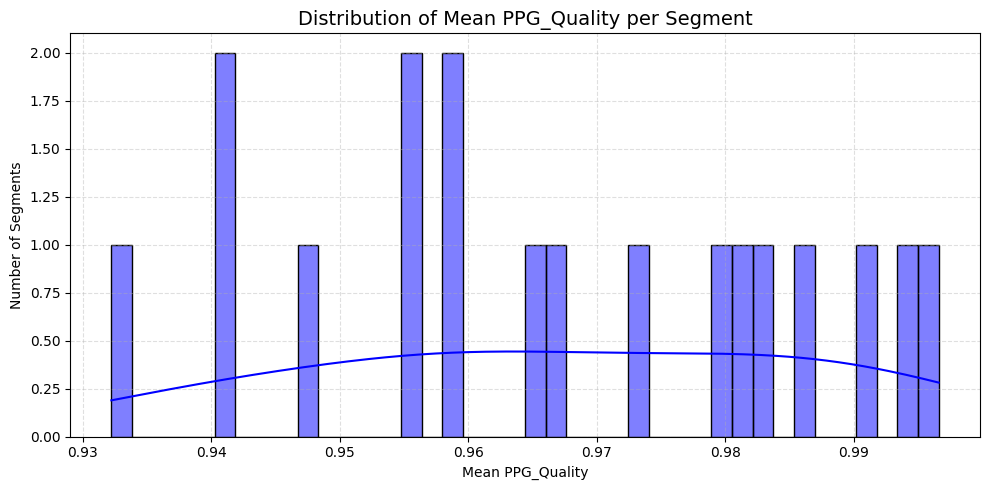

In [75]:
plot_segment_quality_distribution(segments_by_subject_merged)


In [76]:
segments_by_subject_merged.keys()

dict_keys(['3200489', '3201104', '3203174', '3204992', '3205295', '3205707', '3206376', '3207225', '3207652', '3207791', '3208137', '3212414', '3212748', '3212968', '3212996', '3213347', '3213671', '3216832'])

the spesific percentile of the amount 

In [77]:
import random

def sample_subdict(data: dict, percentage: float) -> dict:
    """
    Returns a sub-dictionary sampled from the input dictionary 
    based on a given percentage of its total keys.

    Parameters:
    - data (dict): The original dictionary.
    - percentage (float): The percentage (0–100) of keys to sample.

    Returns:
    - dict: A sub-dictionary containing the sampled keys and values.
    """
    if not (0 < percentage <= 100):
        raise ValueError("Percentage must be between 0 and 100")
    
    total_keys = list(data.keys())
    sample_size = max(1, int(len(total_keys) * (percentage / 100)))
    sampled_keys = random.sample(total_keys, sample_size)
    
    return {k: data[k] for k in sampled_keys}


In [ ]:
cleaned_segments_by_subject = sample_subdict(cleaned_segments_by_subject, 100)  # %100 sample


In [81]:
cleaned_segments_by_subject.keys()

dict_keys(['3207225', '3212968', '3216832', '3207791', '3208137'])

-----------------------------

## Updtate of the ppg (Bottoms of the ppg cycle consideration)

- making the peak to peak consideration to bottom to bottom approach to develop 
    - then we are going to connsider that situation on that meaning to perform the model

In [82]:


cleaned_segments_by_subject["3216832"][0]["info"]



{'method_peaks': 'elgendi',
 'method_fixpeaks': 'None',
 'PPG_Peaks': array([   116,    271,    374, ..., 146047, 146136, 146231]),
 'sampling_rate': 125,
 'PPG_Bottoms': array([    84,    169,    334, ..., 145996, 146112, 146209])}

In [83]:
import numpy as np

def _compute_bottom_indices(signal: np.ndarray, peaks: np.ndarray) -> np.ndarray:
    """
    Find valley (bottom) indices:
      - from 0 → first peak (inclusive)
      - within each [peak_i → peak_{i+1}] interval (inclusive)
    Ties pick the first occurrence.
    """
    peaks = np.asarray(peaks, dtype=int)
    peaks = np.unique(peaks[(peaks >= 0) & (peaks < len(signal))])
    if peaks.size == 0:
        return np.array([], dtype=int)

    bottoms = []

    # First interval: from start to first peak
    seg = signal[0:peaks[0] + 1]
    bottoms.append(int(np.nanargmin(seg)))

    # Between consecutive peaks
    for i in range(len(peaks) - 1):
        s, e = peaks[i], peaks[i + 1]
        if e <= s:
            continue
        seg = signal[s:e + 1]
        local_min = int(np.nanargmin(seg))
        bottoms.append(s + local_min)

    return np.asarray(bottoms, dtype=int)


def add_bottoms_all(cleaned_segments_by_subject: dict,
                    signal_col: str = "PPG_Clean",
                    peaks_key: str = "PPG_Peaks",
                    bottoms_key: str = "PPG_Bottoms"):
    """
    Loop over all subjects and all segments.
    Add bottoms under each segment's info dict.
    """
    for subject_id, seg_list in cleaned_segments_by_subject.items():
        for seg in seg_list:
            # extract signal
            x = seg["data"][signal_col].to_numpy()

            # peaks from info
            peaks = seg["info"][peaks_key]

            # compute bottoms
            bottoms = _compute_bottom_indices(x, peaks)

            # write directly under info
            seg["info"][bottoms_key] = bottoms

    return cleaned_segments_by_subject  # modified in place


In [84]:
reference_segment_by_subject = cleaned_segments_by_subject.copy()

In [85]:
cleaned_segments_by_subject = add_bottoms_all(reference_segment_by_subject)

In [86]:
cleaned_segments_by_subject["3216832"][0]

{'data':            PLETH        ABP    segment_id  sample_index   PPG_Raw  PPG_Clean  \
 0       0.067588  73.363846  3216832_0016             0  0.067588   0.118171   
 1       0.059489  73.559219  3216832_0016             1  0.059489   0.109541   
 2       0.053056  73.510376  3216832_0016             2  0.053056   0.102122   
 3       0.049725  73.315002  3216832_0016             3  0.049725   0.097049   
 4       0.050528  72.973091  3216832_0016             4  0.050528   0.095298   
 ...          ...        ...           ...           ...       ...        ...   
 146245  0.173985  68.674812  3216832_0016        146245  0.173985   0.214765   
 146246  0.154852  68.381744  3216832_0016        146246  0.154852   0.203062   
 146247  0.137015  68.039841  3216832_0016        146247  0.137015   0.192666   
 146248  0.120195  67.746773  3216832_0016        146248  0.120195   0.183218   
 146249  0.104023  67.404861  3216832_0016        146249  0.104023   0.174302   
 
          PPG_Rate

In [87]:
cleaned_segments_by_subject.keys()

dict_keys(['3207225', '3212968', '3216832', '3207791', '3208137'])

In [88]:
import numpy as np
import matplotlib.pyplot as plt

def plot_abp_ppg_with_bottoms(cleaned_segments_by_subject: dict,
                              subject_id,
                              seg_index: int,
                              start_sec: float = 0.0,
                              duration_sec: float = 8.0,
                              abp_col: str = "ABP",
                              ppg_col: str = "PPG_Clean",
                              peaks_key: str = "PPG_Peaks",
                              bottoms_key: str = "PPG_Bottoms",
                              show_peaks: bool = False):
    """
    Plot ABP and PPG in subplots with bottoms marked for a chosen interval.
    Bottoms are shown in red with vertical lines aligned across subplots.
    If show_peaks=True, peaks are also marked in blue.
    """
    seg = cleaned_segments_by_subject[subject_id][seg_index]
    df = seg["data"]
    info = seg["info"]

    fs = info.get("sampling_rate", 125)
    n = len(df)

    # window indices
    start_idx = int(np.clip(start_sec * fs, 0, n - 1))
    end_idx   = int(np.clip(start_idx + duration_sec * fs, start_idx + 1, n))

    # signals in window
    abp = df[abp_col].to_numpy()[start_idx:end_idx]
    ppg = df[ppg_col].to_numpy()[start_idx:end_idx]
    t = np.arange(start_idx, end_idx) / fs

    # ensure bottoms exist
    if bottoms_key not in info or info[bottoms_key] is None or len(info[bottoms_key]) == 0:
        info[bottoms_key] = _compute_bottom_indices(df[ppg_col].to_numpy(), info[peaks_key])

    bottoms = np.asarray(info[bottoms_key], dtype=int)
    mask_btm = (bottoms >= start_idx) & (bottoms < end_idx)
    bottoms_in_window = bottoms[mask_btm]

    # coords for bottoms
    t_btm = bottoms_in_window / fs
    abp_btm = df[abp_col].to_numpy()[bottoms_in_window]
    ppg_btm = df[ppg_col].to_numpy()[bottoms_in_window]

    # if show peaks
    if show_peaks:
        peaks = np.asarray(info[peaks_key], dtype=int)
        mask_pk = (peaks >= start_idx) & (peaks < end_idx)
        peaks_in_window = peaks[mask_pk]
        t_pk = peaks_in_window / fs
        abp_pk = df[abp_col].to_numpy()[peaks_in_window]
        ppg_pk = df[ppg_col].to_numpy()[peaks_in_window]
    else:
        t_pk, abp_pk, ppg_pk = [], [], []

    # ---- plots: ABP top, PPG bottom ----
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    # ABP
    axes[0].plot(t, abp, label="ABP", color='purple')
    axes[0].scatter(t_btm, abp_btm, marker='v', s=60, color='red', label="Bottoms")
    for tb in t_btm:
        axes[0].axvline(tb, color='red', linestyle='--', alpha=0.6)
    if show_peaks:
        axes[0].scatter(t_pk, abp_pk, marker='^', s=60, color='blue', label="Peaks")
        for tp in t_pk:
            axes[0].axvline(tp, color='blue', linestyle='--', alpha=0.6)
    axes[0].set_ylabel("ABP")
    axes[0].legend()
    axes[0].set_title(f"Subject {subject_id} • Segment {seg_index} • {start_sec:.1f}-{start_sec+duration_sec:.1f}s")

    # PPG
    axes[1].plot(t, ppg, label="PPG", color='blue')
    axes[1].scatter(t_btm, ppg_btm, marker='v', s=60, color='red', label="Bottoms")
    for tb in t_btm:
        axes[1].axvline(tb, color='red', linestyle='--', alpha=0.6)
    if show_peaks:
        axes[1].scatter(t_pk, ppg_pk, marker='^', s=60, color='blue', label="Peaks")
        for tp in t_pk:
            axes[1].axvline(tp, color='blue', linestyle='--', alpha=0.6)
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("PPG")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    print(f"Bottoms in window: {len(bottoms_in_window)}")
    if len(bottoms_in_window):
        print("Indices (global):", bottoms_in_window[:20], "..." if len(bottoms_in_window) > 20 else "")
    if show_peaks:
        print(f"Peaks in window: {len(t_pk)}")



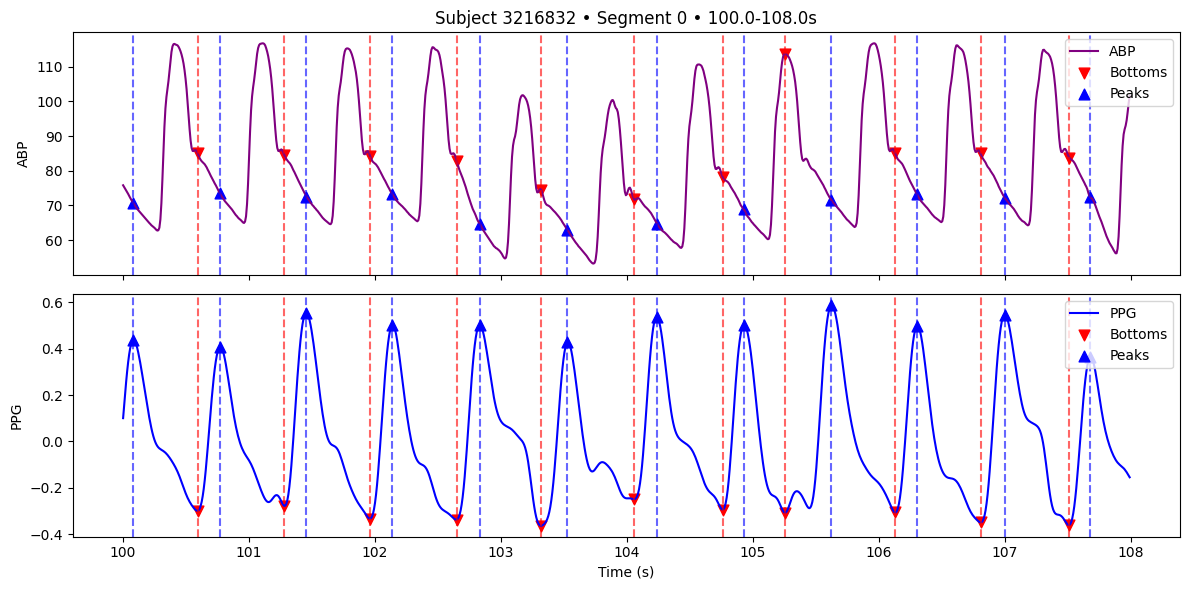

Bottoms in window: 11
Indices (global): [12574 12660 12745 12831 12915 13007 13095 13157 13266 13351 13439] 
Peaks in window: 12


In [89]:
plot_abp_ppg_with_bottoms(cleaned_segments_by_subject, "3216832", 0, start_sec=100, duration_sec=8, show_peaks=True)


----------------------------

## PPG peak based windowed approach 
> using the ppg peaks on the each of the cleaned sample on the working on we preferred some of the window architecture to use on those

In [90]:
import numpy as np
import pandas as pd

def _resample_1d(x, L):
    """Linear resample x -> length L (no scipy). Returns float32."""
    if L <= 1 or len(x) == 0:
        return np.zeros(max(L, 1), dtype=np.float32)
    old_idx = np.linspace(0, 1, num=len(x), endpoint=True, dtype=np.float32)
    new_idx = np.linspace(0, 1, num=L, endpoint=True, dtype=np.float32)
    # np.interp promotes to float64 internally; cast back to float32.
    y = np.interp(new_idx.astype(np.float64),
                  old_idx.astype(np.float64),
                  x.astype(np.float64)).astype(np.float32)
    return y

def extract_beats_with_raw_and_norm(
    subjects_dict,
    peaks_key="PPG_Peaks",
    fs_default=125,
    min_bi_sec=0.33,
    max_bi_sec=1.5,
    target_len=120,
    max_len_ref_sec=1.5,
    skip_if_abp_nan=False,
    delete_after_process=False,
    # --- NEW ---
    quality_col="PPG_Quality",
    quality_mean_min=92.0,       # treat as percent
    quality_scale="auto",        # 'auto'|'0-1'|'0-100'
    store_abp_raw=True,          # memory saver
    astype_float32=True          # downcast stored arrays
):
    """
    Returns a DataFrame with columns (abp_raw is optional):
      ['ppg_norm_120','ppg_raw_120','sbp','dbp','segment_id'] (+ 'abp_raw' if store_abp_raw)
    """
    out = {
        "ppg_norm_120": [],
        "ppg_raw_120": [],
        "sbp": [],
        "dbp": [],
        "segment_id": [],
    }
    if store_abp_raw:
        out["abp_raw"] = []

    for subject_id in list(subjects_dict.keys()):
        segments = subjects_dict[subject_id]
        remaining = []

        for segment in segments:
            df = segment.get("data")
            info = segment.get("info", {}) or {}
            if df is None or 'PPG_Clean' not in df.columns or 'ABP' not in df.columns or 'segment_id' not in df.columns:
                if not delete_after_process:
                    remaining.append(segment)
                continue

            sr = int(info.get("sampling_rate", fs_default))
            seg_id = str(df['segment_id'].iloc[0])

            # Arrays (force float32 here)
            ppg = df['PPG_Clean'].to_numpy(dtype=np.float32)
            abp = df['ABP'].to_numpy(dtype=np.float32)

            # Optional quality array
            q_arr = None
            if quality_col in df.columns:
                q_arr = df[quality_col].to_numpy(dtype=np.float32)

            # ---------- locate peaks ----------
            peaks = None
            pk = info.get(peaks_key, None)
            if isinstance(pk, (list, np.ndarray)):
                peaks = np.asarray(pk, dtype=int)
            if peaks is None and peaks_key in segment and isinstance(segment[peaks_key], (list, np.ndarray)):
                peaks = np.asarray(segment[peaks_key], dtype=int)
            if peaks is None and peaks_key in df.columns:
                col = df[peaks_key].to_numpy()
                if np.issubdtype(col.dtype, np.number):
                    nz = np.where(col != 0)[0]
                    if nz.size > 1:
                        peaks = nz

            if peaks is None or len(peaks) < 2:
                if not delete_after_process:
                    remaining.append(segment)
                continue

            peaks = peaks[(peaks >= 0) & (peaks < len(ppg))]
            if peaks.size < 2:
                if not delete_after_process:
                    remaining.append(segment)
                continue
            peaks = np.unique(np.sort(peaks))

            # --- decide quality scaling once per segment (if available) ---
            scale_mult = np.float32(1.0)
            if q_arr is not None:
                if quality_scale == "0-1":
                    scale_mult = np.float32(100.0)
                elif quality_scale == "0-100":
                    scale_mult = np.float32(1.0)
                else:  # auto
                    med = np.nanmedian(q_arr)
                    scale_mult = np.float32(100.0) if np.isfinite(med) and med <= 1.5 else np.float32(1.0)

            kept = False
            for i in range(len(peaks) - 1):
                a, b = int(peaks[i]), int(peaks[i+1])
                if b <= a + 1:
                    continue

                bi_sec = (b - a) / float(sr)
                if not (min_bi_sec <= bi_sec <= max_bi_sec):
                    continue

                # --- quality gate (if available) ---
                if q_arr is not None:
                    q_mean_pct = scale_mult * np.float32(np.nanmean(q_arr[a:b])) if (b > a) else np.float32(0.0)
                    if not np.isfinite(q_mean_pct) or q_mean_pct < quality_mean_min:
                        continue  # drop low-quality beat

                # Raw beat slices
                ppg_seg = ppg[a:b]
                abp_seg = abp[a:b]

                # Skip if ABP NaNs (optional)
                if skip_if_abp_nan and np.isnan(abp_seg).any():
                    continue

                # Compute resize length
                L = int(max(1, round(bi_sec * target_len / max_len_ref_sec)))
                L = min(L, target_len)

                # Raw resampled + padded (float32)
                ppg_raw_resamp = _resample_1d(ppg_seg, L)
                ppg_raw_fixed = np.pad(ppg_raw_resamp, (0, target_len - L), mode='constant', constant_values=np.float32(0.0)).astype(np.float32)

                # Normalized resampled + padded (float32)
                pmin, pmax = np.nanmin(ppg_seg), np.nanmax(ppg_seg)
                if not np.isfinite(pmin) or not np.isfinite(pmax) or (pmax - pmin) <= 1e-12:
                    continue
                ppg_norm = (ppg_seg - pmin) / (pmax - pmin)
                ppg_norm = ppg_norm.astype(np.float32)
                ppg_norm_resamp = _resample_1d(ppg_norm, L)
                ppg_norm_fixed = np.pad(ppg_norm_resamp, (0, target_len - L), mode='constant', constant_values=np.float32(0.0)).astype(np.float32)

                # SBP/DBP from raw ABP (keep as float32 values)
                if abp_seg.size > 0:
                    sbp = np.float32(np.nanmax(abp_seg))
                    dbp = np.float32(np.nanmin(abp_seg))
                else:
                    sbp = np.float32(np.nan)
                    dbp = np.float32(np.nan)

                # Downcast to float32 to save memory (optional – arrays already float32)
                if astype_float32:
                    ppg_raw_fixed = np.asarray(ppg_raw_fixed, dtype=np.float32)
                    ppg_norm_fixed = np.asarray(ppg_norm_fixed, dtype=np.float32)

                # Collect (lists-of-f32 arrays; SBP/DBP stored as f32 too)
                out["ppg_norm_120"].append(ppg_norm_fixed.tolist())
                out["ppg_raw_120"].append(ppg_raw_fixed.tolist())
                out["sbp"].append(sbp)   # np.float32 scalar
                out["dbp"].append(dbp)   # np.float32 scalar
                out["segment_id"].append(seg_id)
                if store_abp_raw:
                    out["abp_raw"].append(abp_seg.astype(np.float32).tolist() if astype_float32 else abp_seg.tolist())
                kept = True

            if not delete_after_process or not kept:
                remaining.append(segment)

        if delete_after_process:
            if remaining:
                subjects_dict[subject_id] = remaining
            else:
                del subjects_dict[subject_id]

    # Build DataFrame
    df_out = pd.DataFrame(out)

    # Ensure SBP/DBP columns are truly float32 (pandas defaults to float64)
    # This will coerce np.float32 scalars to column dtype float32.
    df_out["sbp"] = df_out["sbp"].astype("float32")
    df_out["dbp"] = df_out["dbp"].astype("float32")

    return df_out


In [91]:
df = extract_beats_with_raw_and_norm(peaks_key="PPG_Peaks", subjects_dict=cleaned_segments_by_subject) # get the dataframe with the beats and the raw and normalized ppg and abp values /-/ we focused to use this one . . . 

C:\Users\taayd\AppData\Local\Temp\ipykernel_28200\3456925236.py:151: RuntimeWarning: All-NaN slice encountered
  sbp = np.float32(np.nanmax(abp_seg))
C:\Users\taayd\AppData\Local\Temp\ipykernel_28200\3456925236.py:152: RuntimeWarning: All-NaN slice encountered
  dbp = np.float32(np.nanmin(abp_seg))


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ppg_norm_120  8721 non-null   object 
 1   ppg_raw_120   8721 non-null   object 
 2   sbp           6730 non-null   float32
 3   dbp           6730 non-null   float32
 4   segment_id    8721 non-null   object 
 5   abp_raw       8721 non-null   object 
dtypes: float32(2), object(4)
memory usage: 340.8+ KB


In [93]:
segment_id_ordered = df["segment_id"].to_list()

In [94]:
segment_id_ordered


['3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005',
 '3207225_0005

-----------------------------

##### database saving 

In [95]:
import os

from collections import defaultdict
import pandas as pd

def summarize_subject_and_segment_counts(segment_id_list):
    """
    Given a list of segment IDs in the form 'subject_segment',
    compute how many unique subjects and total unique segments exist.

    Parameters:
        segment_id_list (list): List of strings like '3100033_0004'

    Returns:
        pd.DataFrame: Summary table with total subjects and total segments
    """
    subject_to_segments = defaultdict(set)

    for full_id in segment_id_list:
        if '_' in full_id:
            subject_id, segment_suffix = full_id.split('_', 1)
            subject_to_segments[subject_id].add(segment_suffix)

    total_subjects = len(subject_to_segments)
    total_segments = sum(len(s) for s in subject_to_segments.values())
    
    return total_subjects, total_segments

total_subjects, total_segments = summarize_subject_and_segment_counts(segment_id_ordered)
# Create the 'dataframes' directory inside /mnt/data
save_dir = "./data/dataframes"
os.makedirs(save_dir, exist_ok=True)

# Save the summary DataFrame there
df.to_pickle(os.path.join(save_dir, f"df_subject_{total_subjects}_segment_{total_segments}_row_{len(segment_id_ordered)}_peak_by_peak_120_sampled.pkl"))

-------------